# Mesh2d refine casulli based on depths

In [1]:
import matplotlib.pyplot as plt
from pathlib import Path

plt.close("all")
import xarray as xr
import numpy as np
import meshkernel
from meshkernel import (
    MakeGridParameters,
    MeshKernel,
    GeometryList,
    GriddedSamples,
    ProjectionType,
    MeshRefinementParameters,
    RefinementType,
    InterpolationType,
    InterpolationParameters
)

mk_version = meshkernel.__version__

# Example 1: refine cartesian mesh

In [2]:
mk = MeshKernel(ProjectionType.CARTESIAN)

x_start, x_end = 0, 10000
y_min, y_max = 0, 10000
num_samples = 100

makeGridParameters = MakeGridParameters()
makeGridParameters.origin_x = x_start
makeGridParameters.origin_y = y_min
makeGridParameters.upper_right_x = x_end
makeGridParameters.upper_right_y = y_max
makeGridParameters.block_size_x = 1000
makeGridParameters.block_size_y = 1000

mk.mesh2d_make_rectangular_mesh_on_extension(makeGridParameters)

### Plot starting cartesian mesh

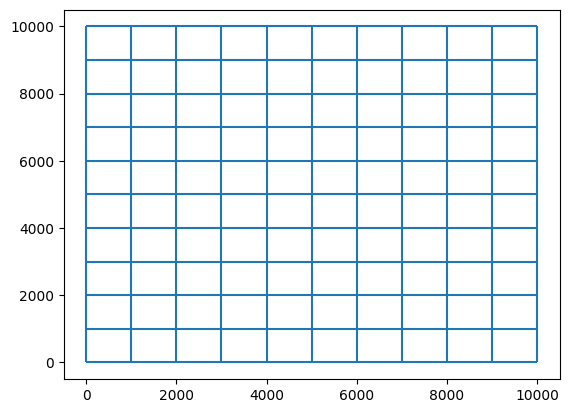

In [3]:
mesh2d_not_refined = mk.mesh2d_get()
fig, ax = plt.subplots()
mesh2d_not_refined.plot_edges(ax)

In [4]:
x_grid, y_grid = np.meshgrid(
    np.linspace(x_start, x_end, num_samples), np.linspace(y_min, y_max, num_samples)
)
values = np.array(np.interp(x_grid, [x_start, x_end], [-10.0, 5.0]), dtype=np.double)

### Plot sample set

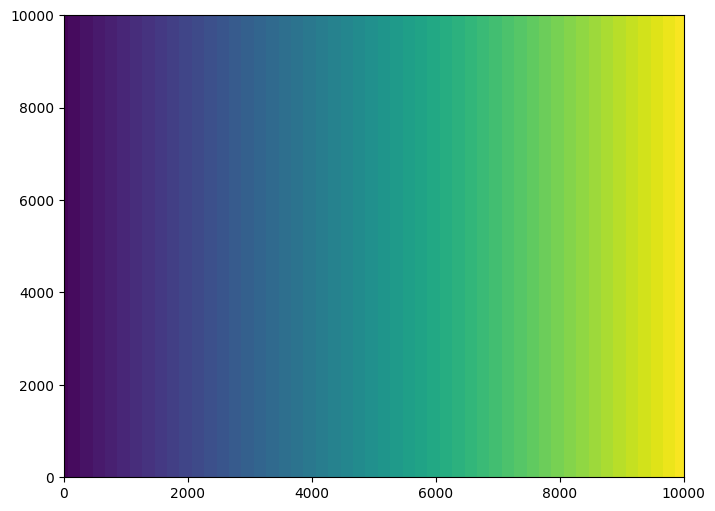

In [5]:
plt.figure(figsize=(8, 6))
plt.contourf(x_grid, y_grid, values, levels=50)

In [6]:
samples = GeometryList(
    x_coordinates=np.array(x_grid.flatten(), dtype=np.double),
    y_coordinates=np.array(y_grid.flatten(), dtype=np.double),
    values=np.array(values.flatten(), dtype=np.double),
)
interpolation_parameters = InterpolationParameters()
interpolation_parameters.interpolation_type = InterpolationType.AVERAGING

property_id = mk.mkernel_set_property(interpolation_parameters, samples)

x_coordinates_pol = np.empty(0, dtype=np.double)
y_coordinates_pol = np.empty(0, dtype=np.double)
polygons = GeometryList(
    x_coordinates=x_coordinates_pol, y_coordinates=y_coordinates_pol
)

meshRefinementParameters = MeshRefinementParameters()
minimumRefinementDepth = 0.0
mk.mkernel_mesh2d_casulli_refinement_based_on_depths(
    polygons, property_id, meshRefinementParameters, minimumRefinementDepth
)

### Plot refined mesh (this must change)

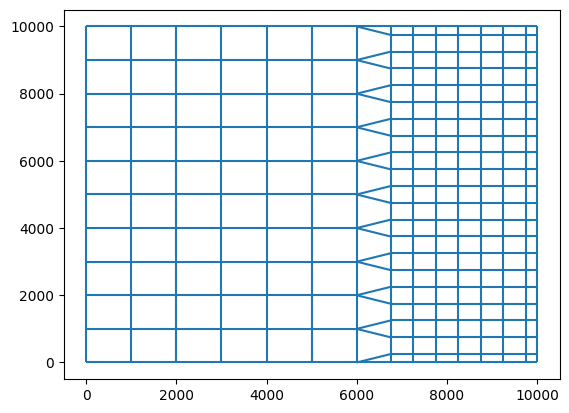

In [7]:
mesh2d_refined = mk.mesh2d_get()
fig, ax = plt.subplots()
mesh2d_refined.plot_edges(ax)

# Example 2: Refining the Analysis Using Real Bathymetric Data in a Smaller Region

## Utility for reading samples

In [8]:
def read_and_filter_samples(file_path, lower_left, upper_right):
    """
    Reads a text file of samples (lat, long, depth), filters samples within a bounding box,
    and returns three numpy arrays of doubles (latitude, longitude, depth).

    :param file_path: Path to the text file containing the data.
    :param lower_left: Tuple with (latitude, longitude) of the lower-left corner of the bounding box.
    :param upper_right: Tuple with (latitude, longitude) of the upper-right corner of the bounding box.
    :return: Tuple of three numpy arrays: latitudes, longitudes, depths.
    """
    latitudes = []
    longitudes = []
    depths = []

    # Unpack bounding box corners
    ll_lat, ll_long = lower_left
    ur_lat, ur_long = upper_right

    try:
        with open(file_path, "r") as file:
            for line in file:
                # Parse the line into latitude, longitude, and depth
                parts = line.strip().split("\t")
                if len(parts) != 3:
                    continue

                try:
                    lat, long, depth = map(float, parts)
                except ValueError:
                    continue

                # Check if the sample is within the bounding box
                if ll_lat <= lat <= ur_lat and ll_long <= long <= ur_long:
                    latitudes.append(lat)
                    longitudes.append(long)
                    depths.append(depth)

    except FileNotFoundError:
        print(f"Error: File {file_path} not found.")
        return (
            np.array([], dtype=np.double),
            np.array([], dtype=np.double),
            np.array([], dtype=np.double),
        )
    except Exception as e:
        print(f"An error occurred: {e}")
        return (
            np.array([], dtype=np.double),
            np.array([], dtype=np.double),
            np.array([], dtype=np.double),
        )

    # Convert lists to numpy arrays of type double
    return (
        np.array(latitudes, dtype=np.double),
        np.array(longitudes, dtype=np.double),
        np.array(depths, dtype=np.double),
    )

In [9]:
input_file = "stpete.xyz"
input_file_path = Path().absolute() / "data_examples" / input_file

lower_left_corner = (-82.79428, 28.00218)
upper_right_corner = (-82.76323, 28.02404)
# Read and filter the samples
x_coordinates, y_coordinates, values = read_and_filter_samples(
    input_file_path, lower_left_corner, upper_right_corner
)

### Generate regular grid

In [10]:
lon_min, lon_max, lat_min, lat_max = -82.79428, -82.76323, 28.00218, 28.02404
dx = (lon_max - lon_min) / 10.0
dy = (lat_max - lat_min) / 10.0

makeGridParameters = MakeGridParameters(
    angle=0,
    origin_x=lon_min,
    origin_y=lat_min,
    upper_right_x=lon_max,
    upper_right_y=lat_max,
    block_size_x=dx,
    block_size_y=dy,
)

mk = MeshKernel(projection=ProjectionType.SPHERICAL)
mk.mesh2d_make_rectangular_mesh(makeGridParameters)

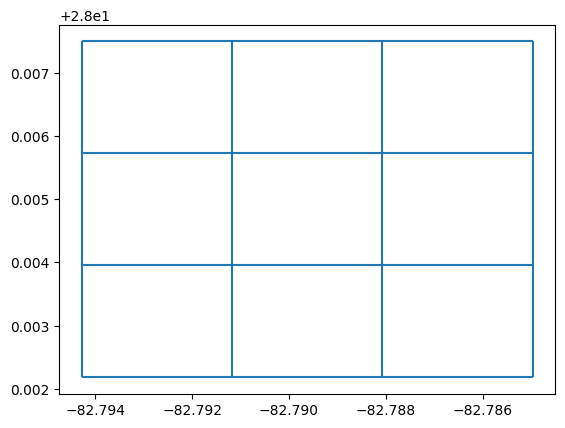

In [11]:
mesh2d_not_refined = mk.mesh2d_get()
fig, ax = plt.subplots()
mesh2d_not_refined.plot_edges(ax)

In [12]:
samples = GeometryList(
    x_coordinates=x_coordinates, y_coordinates=y_coordinates, values=values
)

In [13]:
interpolation_parameters = InterpolationParameters()
interpolation_parameters.interpolation_type = InterpolationType.AVERAGING

property_id = mk.mkernel_set_property(interpolation_parameters, samples)

x_coordinates_pol = np.empty(0, dtype=np.double)
y_coordinates_pol = np.empty(0, dtype=np.double)
polygons = GeometryList(
    x_coordinates=x_coordinates_pol, y_coordinates=y_coordinates_pol
)

meshRefinementParameters = MeshRefinementParameters()
minimumRefinementDepth = 0.0
mk.mkernel_mesh2d_casulli_refinement_based_on_depths(
    polygons, property_id, meshRefinementParameters, minimumRefinementDepth
)

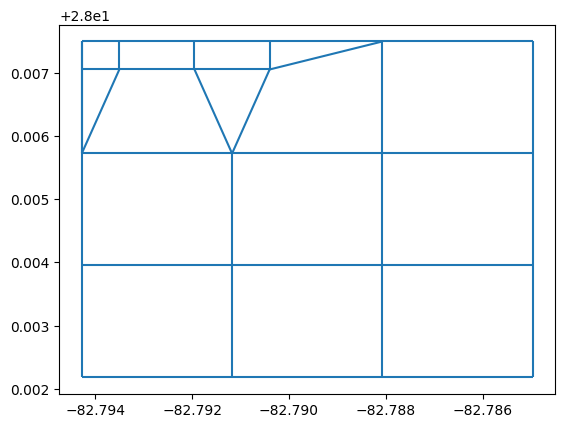

In [14]:
mesh2d_refined = mk.mesh2d_get()
fig, ax = plt.subplots()
mesh2d_refined.plot_edges(ax)